# Conv Vae Fmnist

In [1]:
import os 
import glob as glob
import random
import time

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
from typeguard import typechecked

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Download F_mnist data set from: https://www.kaggle.com/zalando-research/fashionmnist

In [2]:
X_train = pd.read_csv("F_mnist/train.csv")
X_test = pd.read_csv("F_mnist/test.csv")

In [3]:
X_train = X_train.iloc[:,2:].values
X_valid = X_test.iloc[:,1:].values

X_train, X_valid = X_train/255, X_valid/255

In [4]:
X_train = X_train.reshape(X_train.shape[0],28,28)
X_valid = X_valid.reshape(X_valid.shape[0],28,28)

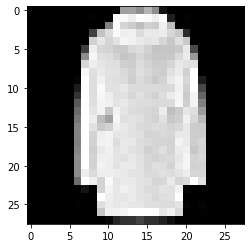

In [22]:
plt.imshow(X_train[6,:,:], cmap="gray")
plt.show()

## Custom Model with fit()

In [6]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.math.exp(log_var / 2) + mean
    
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))    

In [7]:
class SpectralNormalization(tf.keras.layers.Wrapper):
    """Performs spectral normalization on weights.
    This wrapper controls the Lipschitz constant of the layer by
    constraining its spectral norm, which can stabilize the training of GANs.
    See [Spectral Normalization for Generative Adversarial Networks](https://arxiv.org/abs/1802.05957).
    ```python
    net = SpectralNormalization(
        tf.keras.layers.Conv2D(2, 2, activation="relu"),
        input_shape=(32, 32, 3))(x)
    net = SpectralNormalization(
        tf.keras.layers.Conv2D(16, 5, activation="relu"))(net)
    net = SpectralNormalization(
        tf.keras.layers.Dense(120, activation="relu"))(net)
    net = SpectralNormalization(
        tf.keras.layers.Dense(n_classes))(net)
    ```
    Arguments:
      layer: A `tf.keras.layers.Layer` instance that
        has either `kernel` or `embeddings` attribute.
      power_iterations: `int`, the number of iterations during normalization.
    Raises:
      AssertionError: If not initialized with a `Layer` instance.
      ValueError: If initialized with negative `power_iterations`.
      AttributeError: If `layer` does not has `kernel` or `embeddings` attribute.
    """

    @typechecked
    def __init__(self, layer: tf.keras.layers, power_iterations: int = 10, **kwargs):
        super().__init__(layer, **kwargs)
        if power_iterations <= 0:
            raise ValueError(
                "`power_iterations` should be greater than zero, got "
                "`power_iterations={}`".format(power_iterations)
            )
        self.power_iterations = power_iterations
        self._initialized = False

    def build(self, input_shape):
        """Build `Layer`"""
        super().build(input_shape)
        input_shape = tf.TensorShape(input_shape)
        self.input_spec = tf.keras.layers.InputSpec(shape=[None] + input_shape[1:])

        if hasattr(self.layer, "kernel"):
            self.w = self.layer.kernel
        elif hasattr(self.layer, "embeddings"):
            self.w = self.layer.embeddings
        else:
            raise AttributeError(
                "{} object has no attribute 'kernel' nor "
                "'embeddings'".format(type(self.layer).__name__)
            )

        self.w_shape = self.w.shape.as_list()

        self.u = self.add_weight(
            shape=(1, self.w_shape[-1]),
            initializer=tf.initializers.TruncatedNormal(stddev=0.02),
            trainable=False,
            name="sn_u",
            dtype=self.w.dtype,
        )

    def call(self, inputs, training=None):
        """Call `Layer`"""
        if training is None:
            training = tf.keras.backend.learning_phase()

        if training:
            self.normalize_weights()

        output = self.layer(inputs)
        return output

    def compute_output_shape(self, input_shape):
        return tf.TensorShape(self.layer.compute_output_shape(input_shape).as_list())

    @tf.function
    def normalize_weights(self):
        """Generate spectral normalized weights.
        This method will update the value of `self.w` with the
        spectral normalized value, so that the layer is ready for `call()`.
        """

        w = tf.reshape(self.w, [-1, self.w_shape[-1]])
        u = self.u

        with tf.name_scope("spectral_normalize"):
            for _ in range(self.power_iterations):
                v = tf.math.l2_normalize(tf.matmul(u, w, transpose_b=True))
                u = tf.math.l2_normalize(tf.matmul(v, w))

            sigma = tf.matmul(tf.matmul(v, w), u, transpose_b=True)

            self.w.assign(self.w / sigma)
            self.u.assign(u)

    def get_config(self):
        config = {"power_iterations": self.power_iterations}
        base_config = super().get_config()
        return {**base_config, **config}

In [8]:
class VAE(Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

In [9]:
codings_size = 20
n_pixels = 28*28

inputs = keras.layers.Input(shape=[28, 28,1])
z = keras.layers.Conv2D(filters=12, kernel_size=3, strides=(2, 2),activation='relu')(inputs)
z = keras.layers.Conv2D(filters=6, kernel_size=3, strides=(2, 2),activation='relu')(z)
z = keras.layers.Flatten()(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
encoder = keras.models.Model(
inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])
print(encoder.summary())
    
# Declare decoder
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(units=196, activation=tf.nn.relu)(decoder_inputs)
x = tf.keras.layers.Reshape(target_shape=(7, 7, 4))(x)
x = tf.keras.layers.Conv2DTranspose(filters=6, kernel_size=3, strides=2, padding='same',
                    activation='relu')(x)
x = tf.keras.layers.Conv2DTranspose(filters=12, kernel_size=3, strides=2, padding='same',
                    activation='relu')(x)
outputs = SpectralNormalization(tf.keras.layers.Conv2DTranspose(activation='sigmoid',
                    filters=1, kernel_size=3, strides=1, padding='same'))(x)
decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])
print(decoder.summary())
        
# Declare VAE
_, _, codings = encoder(inputs)
reconstructions = decoder(codings)

vae = VAE(inputs=[inputs], outputs=[reconstructions])  

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 13, 13, 12)   120         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 6, 6, 6)      654         conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 216)          0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## Train model

In [10]:
latent_loss = -0.5 * tf.math.reduce_sum(
    1 + codings_log_var - tf.math.exp(codings_log_var) - tf.math.square(codings_mean),
    axis=-1)

vae.add_loss(tf.math.reduce_mean(latent_loss) / n_pixels)
vae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = vae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
469/469 [==============================] - 18s 37ms/step - loss: 0.4386 - rounded_accuracy: 0.8007 - val_loss: 0.3812 - val_rounded_accuracy: 0.8644
Epoch 2/25
469/469 [==============================] - 19s 40ms/step - loss: 0.3669 - rounded_accuracy: 0.8792 - val_loss: 0.3553 - val_rounded_accuracy: 0.8899
Epoch 3/25
469/469 [==============================] - 24s 50ms/step - loss: 0.3514 - rounded_accuracy: 0.8923 - val_loss: 0.3450 - val_rounded_accuracy: 0.8978
Epoch 4/25
469/469 [==============================] - 28s 60ms/step - loss: 0.3435 - rounded_accuracy: 0.8979 - val_loss: 0.3399 - val_rounded_accuracy: 0.9009
Epoch 5/25
469/469 [==============================] - 27s 58ms/step - loss: 0.3390 - rounded_accuracy: 0.9016 - val_loss: 0.3354 - val_rounded_accuracy: 0.9047
Epoch 6/25
469/469 [==============================] - 23s 49ms/step - loss: 0.3361 - rounded_accuracy: 0.9040 - val_loss: 0.3348 - val_rounded_accuracy: 0.9051
Epoch 7/25
469/469 [====================

## Generate Sample

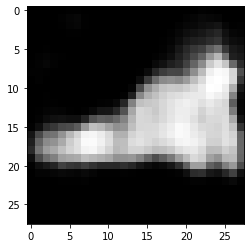

In [40]:
codings = tf.random.normal(shape=[1, codings_size])
images = decoder(codings).numpy()
plt.imshow(images[0,:,:,0], cmap="gray")
plt.show()

In [12]:
images.shape

(1, 28, 28, 1)